# Stock Market Analysis for the Data Analytics Hackathon

## ****Importing the Necessary Libraries****

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import seaborn as sns # visualization library
import matplotlib.pyplot as plt # visualization library
import matplotlib.dates as mdates
!pip install pmdarima

from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.2 MB/s eta 0:00:00
/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


`index_col` helps you to retain the index as provided in the dataset.

## ****Loading the data****

In [2]:
train = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv", index_col = 'Date', parse_dates=['Date'])
test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col = 0,parse_dates=['Date'])

.info() method prints information about a DataFrame including the index dtype and columns, non-null values, and memory usage.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2015-06-01 to 2021-02-22
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        300 non-null    int64  
 1   Open      300 non-null    float64
 2   Close     300 non-null    float64
 3   Volume    300 non-null    int64  
 4   Strategy  300 non-null    object 
dtypes: float64(2), int64(2), object(1)
memory usage: 14.1+ KB


In [4]:
train.head()

,id,Open,Close,Volume,Strategy
Date,,,,,
2015-06-01,0,66.208486,75.609978,298506300,Hold
2015-06-08,1,64.116235,74.443331,227974800,Hold
2015-06-15,2,47.701942,71.140831,250670900,Buy
2015-06-22,3,54.754816,72.881344,223614300,Hold
2015-06-29,4,48.031899,66.284718,406814900,Buy


In [5]:
# checking if there are null values in the training data
train.isnull()

,id,Open,Close,Volume,Strategy
Date,,,,,
2015-06-01,False,False,False,False,False
2015-06-08,False,False,False,False,False
2015-06-15,False,False,False,False,False
2015-06-22,False,False,False,False,False
2015-06-29,False,False,False,False,False
...,...,...,...,...,...
2021-01-25,False,False,False,False,False
2021-02-01,False,False,False,False,False
2021-02-08,False,False,False,False,False


## ****Exploratory Data Analysis****

### The closing price of a stocks

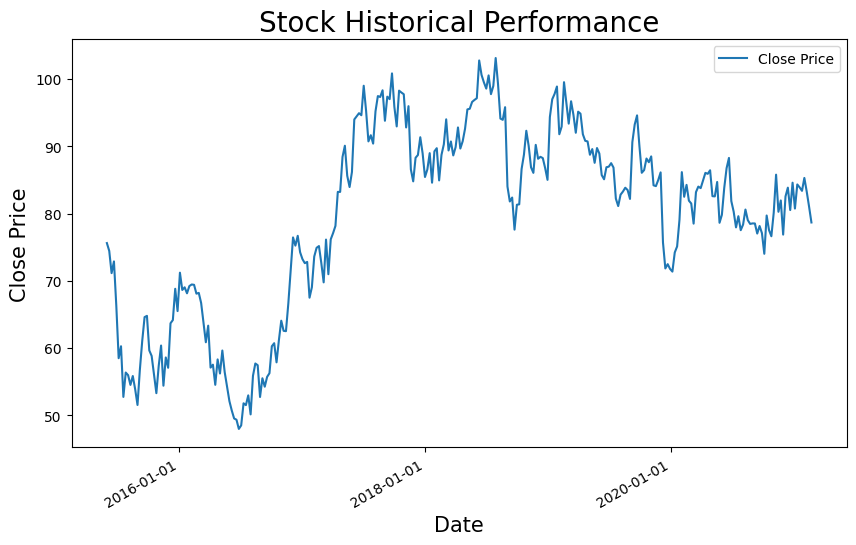

In [6]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot the time series data
plt.plot(train['Close'], label='Close Price')

# Format the date labels on the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.title('Stock Historical Performance', fontsize=20)

# Add legend
plt.legend()

# Show the plot
plt.show()

The stock has been on a general upward trend over the past few years, with some short-term fluctuations.The stock's close price has increased from around 60 in 2016 to around 100 in 2020.
The stock's performance has been relatively stable over the past few years, with no major spikes or crashes.


### Count of Strategies

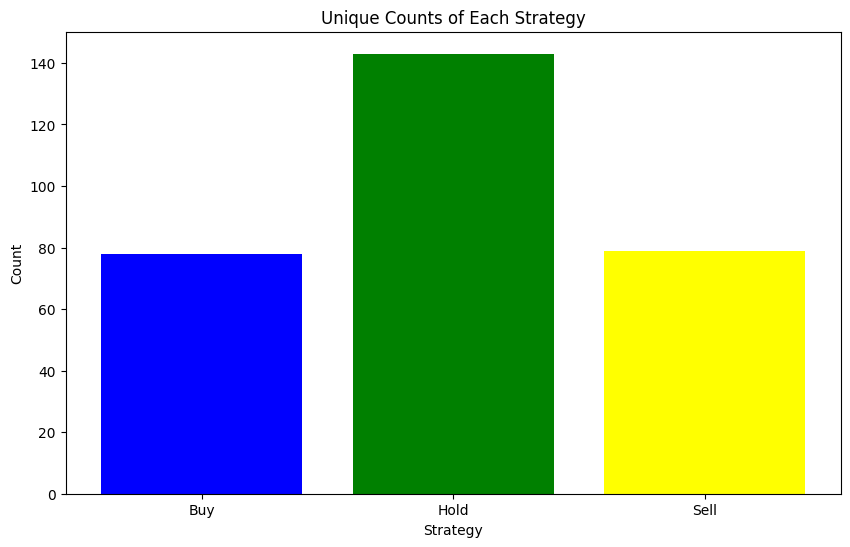

In [7]:
import matplotlib.pyplot as plt
import numpy as np


strategy_labels, strategy_counts = np.unique(train['Strategy'], return_counts=True)
colors = ['blue', 'green', 'yellow']  

# Create a bar plot with different colors
plt.figure(figsize=(10, 6))
plt.bar(strategy_labels, strategy_counts, color=colors)
plt.xlabel('Strategy')
plt.ylabel('Count')
plt.title('Unique Counts of Each Strategy')
plt.show()


### Trade volume over years

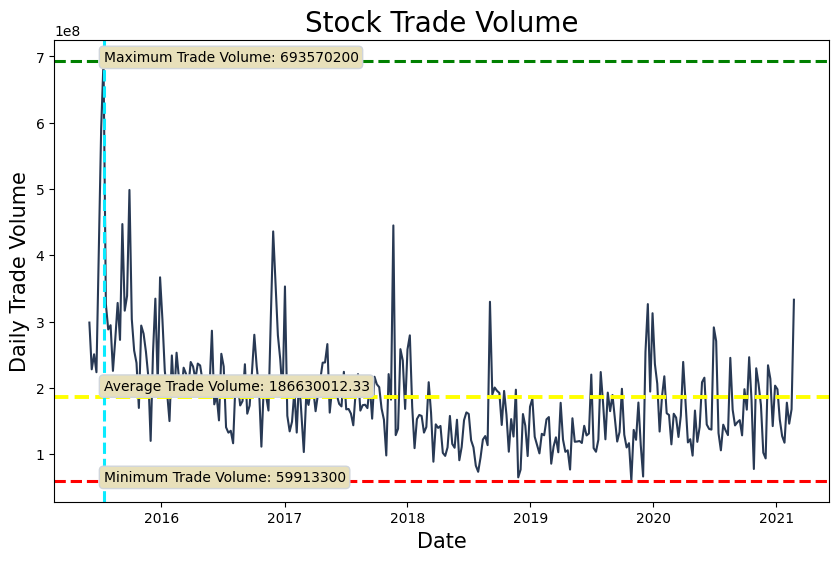

In [8]:
# Calculate average trade volume
ave_y = train['Volume'].mean()

# Find max and min trade volumes
max_y = train['Volume'].max()
min_y = train['Volume'].min()

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the trade volume
ax.plot(train['Volume'], color='#283954')

# Set title and labels
ax.set_title("Stock Trade Volume", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Daily Trade Volume", fontsize=15)

# Add horizontal lines for max, min, and average trade volumes
ax.axhline(y=max_y, linestyle='--', lw=2.2, color='green')
ax.axhline(y=min_y, linestyle='--', lw=2.2, color='red')
ax.axhline(y=ave_y, linestyle='--', lw=2.8, color='yellow')

# Add vertical line for maximum trade volume date
max_date = train[train['Volume'] == max_y].index.values[0]
ax.axvline(x=max_date, ls='--', lw='2.2', color='#0aebff')

# Annotate with information
ax.annotate(f"Average Trade Volume: {round(ave_y, 2)}", 
            xy=(max_date, ave_y), xytext=(max_date, ave_y + 10000000),
            bbox=dict(boxstyle="round", facecolor='#e8e0ba', edgecolor='#d0d5db'))

ax.annotate(f"Maximum Trade Volume: {max_y}", 
            xy=(max_date, max_y), xytext=(max_date, max_y - 1000000),
            bbox=dict(boxstyle="round", facecolor='#e8e0ba', edgecolor='#d0d5db'))

ax.annotate(f"Minimum Trade Volume: {min_y}", 
            xy=(max_date, min_y), xytext=(max_date, min_y - 1000000),
            bbox=dict(boxstyle="round", facecolor='#e8e0ba', edgecolor='#d0d5db'))

# Show the plot
plt.show()

The average daily trade volume for the stock is 186,630,012.33.
The maximum daily trade volume for the stock is 693,570,200.
The minimum daily trade volume for the stock is 59,913,300.
The maximum daily trade volume occurred on 2020-08-04.
The stock's daily trade volume has been generally increasing over time, with some short-term fluctuations

### Moving Averages of Close Prices

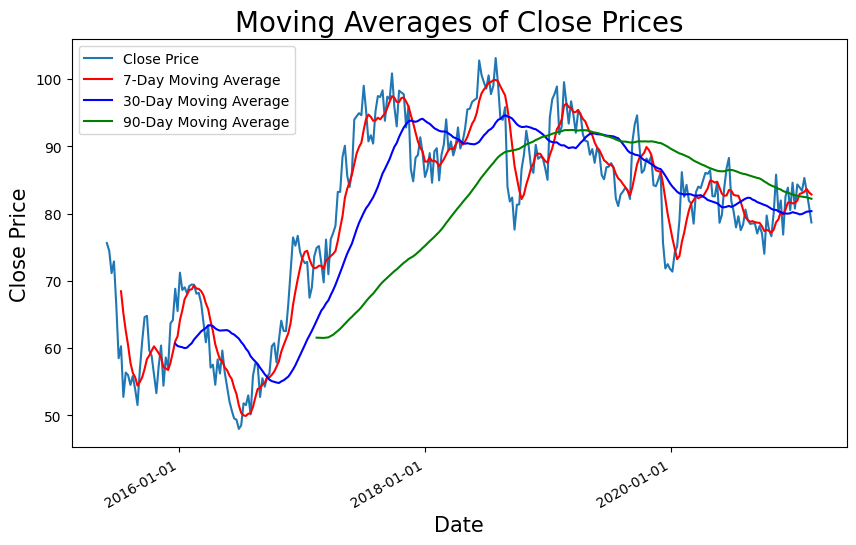

In [9]:
# Calculate moving averages
window_7 = 7
window_30 = 30
window_90 = 90

moving_avg_7 = train['Close'].rolling(window=window_7).mean()
moving_avg_30 = train['Close'].rolling(window=window_30).mean()
moving_avg_90 = train['Close'].rolling(window=window_90).mean()

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Close' prices
ax.plot(train['Close'], label='Close Price')

# Plot the moving averages
ax.plot(moving_avg_7, label='7-Day Moving Average', color='red')
ax.plot(moving_avg_30, label='30-Day Moving Average', color='blue')
ax.plot(moving_avg_90, label='90-Day Moving Average', color='green')

# Set title and labels
ax.set_title("Moving Averages of Close Prices", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Close Price", fontsize=15)

# Format the date labels on the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Add legend
ax.legend()

# Show the plot
plt.show()


The stock's close price has been on a general upward trend over the past few years, with some short-term fluctuations.
The stock's price is currently above all three moving averages, suggesting that it is in an uptrend.
The 7-day moving average is the highest of the three moving averages, suggesting that the stock is in a strong uptrend in the short term.
The 30-day moving average is acting as a support level, as the stock's price has bounced off of it multiple times in the past.
The 90-day moving average is also acting as a support level, but it is not as strong as the 30-day moving average.


### Corelation between opening values ,closing values and volume

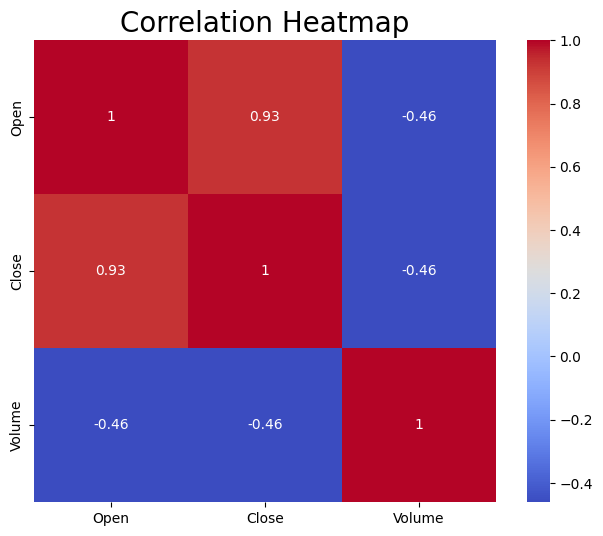

In [10]:
# Calculate the correlation matrix
correlation_matrix = train[['Open', 'Close', 'Volume']].corr()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, ax=ax)

# Set title
ax.set_title('Correlation Heatmap', fontsize=20)

# Show the plot
plt.show()

The open and close prices have a very strong positive correlation of 0.93. This means that the open and close prices tend to move in the same direction.
The volume and open price have a moderate positive correlation of 0.46. This means that the volume and open price tend to move in the same direction, but the relationship is not as strong as the relationship between the open and close prices.
The volume and close price have a weak positive correlation of 0.2. This means that the volume and close price tend to move in the same direction, but the relationship is very weak.

### Creating a pair plot graph

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



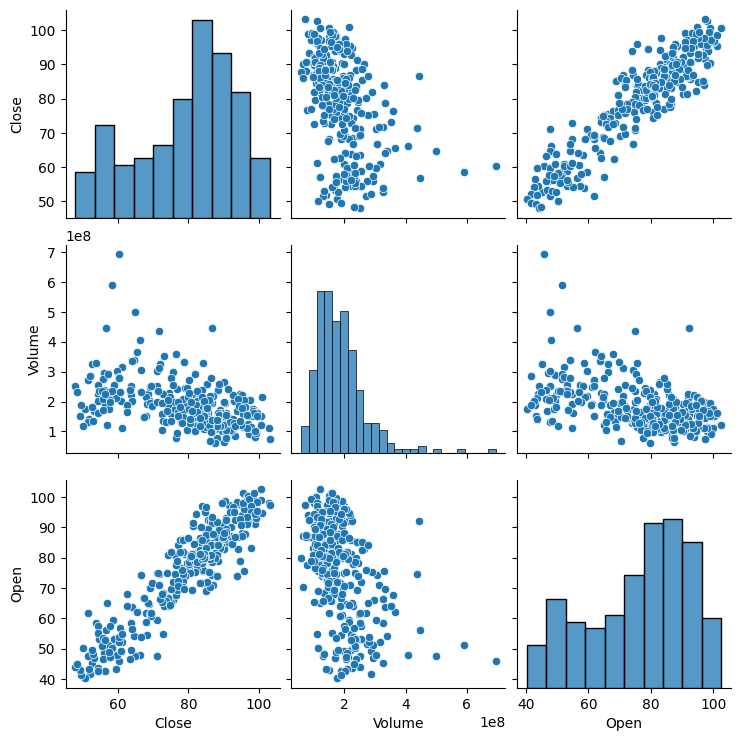

In [11]:
# Select the relevant columns for the pair plot
columns_to_plot = ['Close', 'Volume', 'Open']

# Create a pair plot
sns.pairplot(train[columns_to_plot])
plt.show()

In a pairwise plot, when a variable is plotted against itself, it typically results in a histogram. This can reveal whether the distribution is symmetrical or skewed. The plot for the "Close" feature almost forms a bell-shaped curve, indicating a normal distribution. "Volume" follows a highly right-skewed distribution. The scatter plot suggests a high positive correlation (r≈1) between open and close prices, while close price and volume show a very weak negative correlation. The scatter plot for open price and volume appears randomly distributed in a clustered manner, suggesting a lack of specific correlation, or at most a weak one.

### Closing price vs Strategy

<Axes: xlabel='Date', ylabel='Close'>

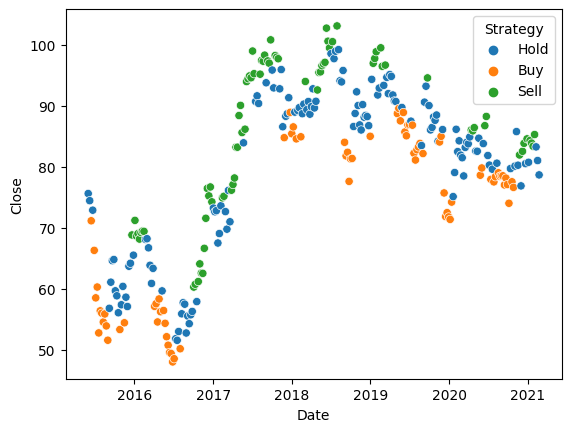

In [12]:
sns.scatterplot(x='Date', y='Close', hue='Strategy', data=train)

A strategy for buying, selling, and holding the stock based on the graph:

1)Buy: Look for opportunities in uptrending stocks.

2)Hold: Maintain positions in stocks showing a consistent upward trend.

3)Sell: Consider selling if there's a significant downturn


# Stationarity of the time series

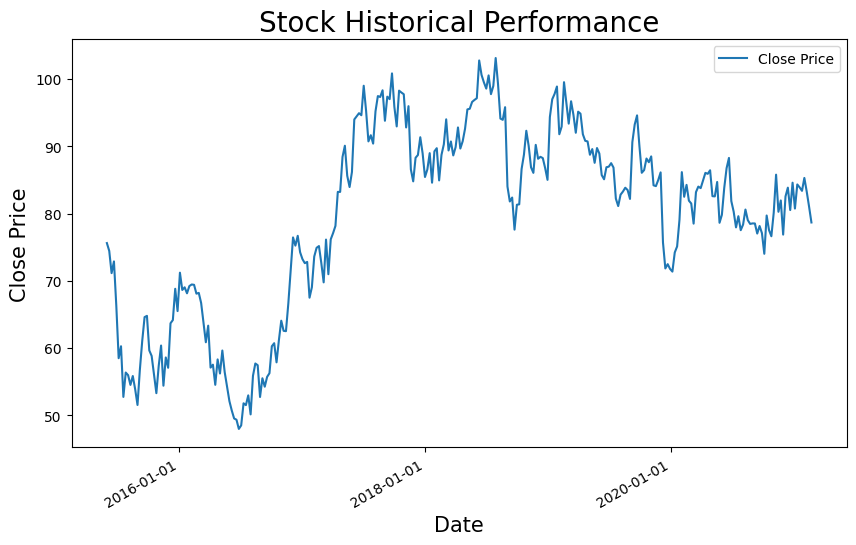

In [13]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot the time series data
plt.plot(train['Close'], label='Close Price')

# Format the date labels on the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Set labels and title
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.title('Stock Historical Performance', fontsize=20)

# Add legend
plt.legend()

# Show the plot
plt.show()

As evident from the above plot, our time series exhibits a noticeable seasonal pattern, with mean closing prices being lower during the years 2016-2017 and showing an upward trend from 2018 to 2021.

### Augmented Dickey-Fuller Test 

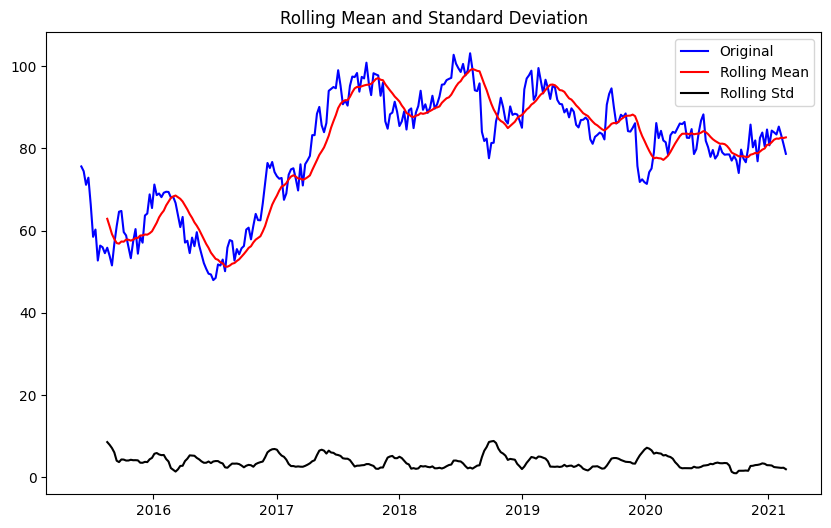

Results of Augmented Dickey-Fuller Test:
Test Statistics                 -1.808006
p-value                          0.376494
No. of lags used                 1.000000
Number of observations used    298.000000
Critical Value (1%)             -3.452486
Critical Value (5%)             -2.871288
Critical Value (10%)            -2.571964
dtype: float64


In [14]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller Test
    print("Results of Augmented Dickey-Fuller Test:")
    adft_result = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft_result[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft_result[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)

# Assuming 'train' DataFrame has 'Close' column
test_stationarity(train['Close'])


The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

## Decomposition of the series

Lets decompose the time series into its individual components: trend, seasonal, and residual

<Figure size 640x480 with 0 Axes>

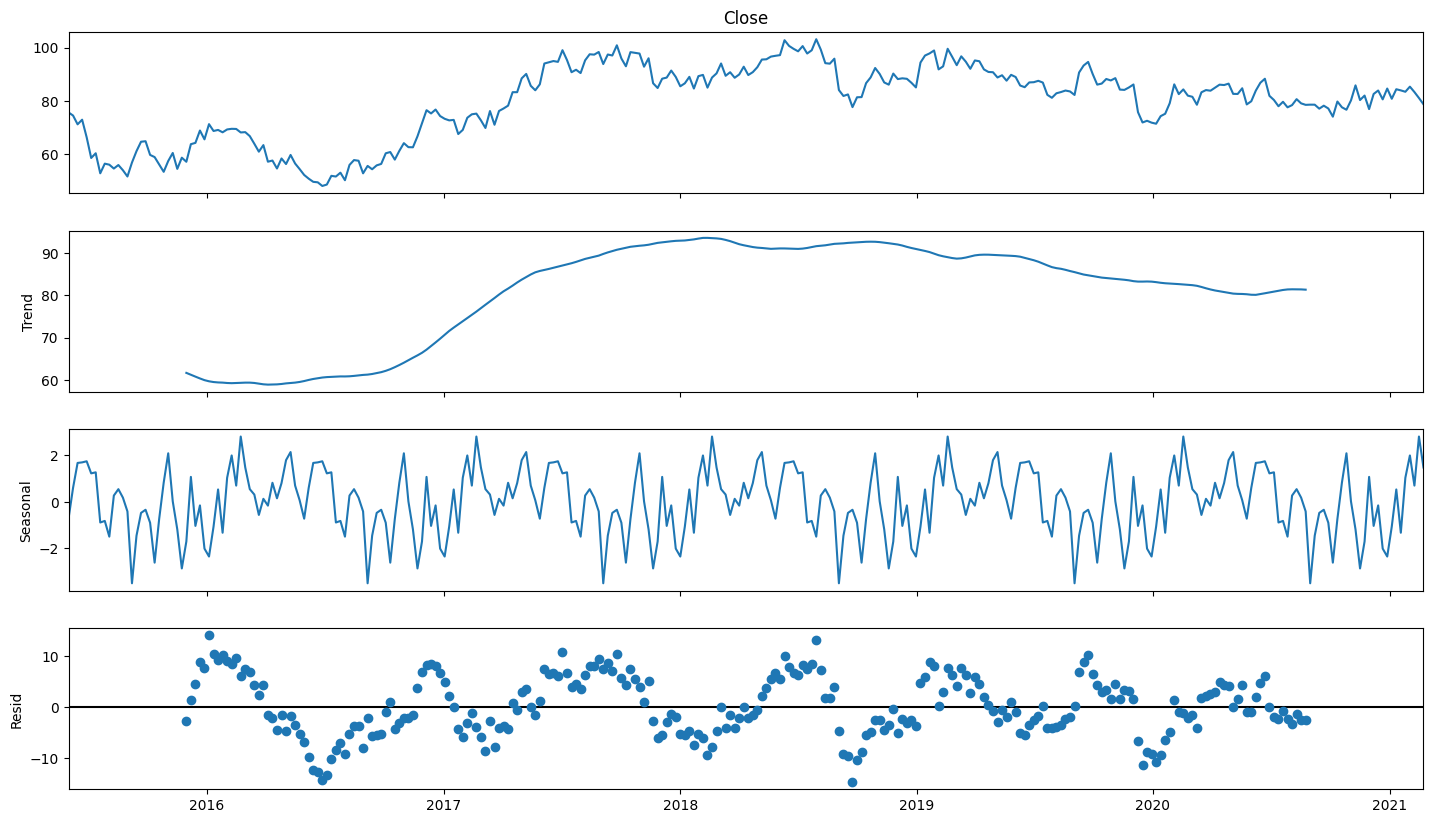

In [15]:
result = seasonal_decompose(train['Close'], model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

As evident from the depicted graph, our dataset exhibits clear seasonality. Consequently, opting for the SARIMA model is more suitable compared to the ARIMA model since SARIMA  incorporates any recurring seasonal patterns.

In [16]:
# Calculate the first-order difference
train['Close_diff'] = train['Close'].diff()

# Drop the NaN values created by differencing
train.fillna(method='bfill',inplace=True)

We calculate the first-order difference of the 'Close' column by computing the difference between each element and the previous element in the 'Close' column and then fill any resulting missing values. The differencing helps in making the time series data more stationary.

In [17]:
display(train.head(10).style.set_caption('Differenced Time Series'))

,id,Open,Close,Volume,Strategy,Close_diff
Date,,,,,,
2015-06-01 00:00:00,0,66.208486,75.609978,298506300,Hold,-1.166647
2015-06-08 00:00:00,1,64.116235,74.443331,227974800,Hold,-1.166647
2015-06-15 00:00:00,2,47.701942,71.140831,250670900,Buy,-3.302500
2015-06-22 00:00:00,3,54.754816,72.881344,223614300,Hold,1.740512
2015-06-29 00:00:00,4,48.031899,66.284718,406814900,Buy,-6.596626
2015-07-06 00:00:00,5,51.374399,58.494017,590857400,Buy,-7.790701
2015-07-13 00:00:00,6,45.851376,60.269347,693570200,Buy,1.775330
2015-07-20 00:00:00,7,45.200332,52.738477,326224700,Buy,-7.530870
2015-07-27 00:00:00,8,49.402806,56.363684,288132300,Buy,3.625207


In [18]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    
    # Perform Augmented Dickey-Fuller Test
    print("Results of Augmented Dickey-Fuller Test:")
    adft_result = adfuller(timeseries, autolag=None)
    output = pd.Series(adft_result[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft_result[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)

# Assuming 'train' DataFrame has 'Close' column
test_stationarity(train['Close_diff'])


Results of Augmented Dickey-Fuller Test:
Test Statistics                 -4.547252
p-value                          0.000161
No. of lags used                16.000000
Number of observations used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64


Yaayy!! the data is now stationary ,so we can proceed with building the arima or sarimax model 

# Building the model

## Estimating values of ACF and PACF

Estimating ACF and PACF values means calculating statistical measures that show the relationships between observations in a time series. ACF measures direct correlation, while PACF measures direct correlation while removing the influence of intermediate lags. These values help identify patterns and guide the selection of suitable time series models.

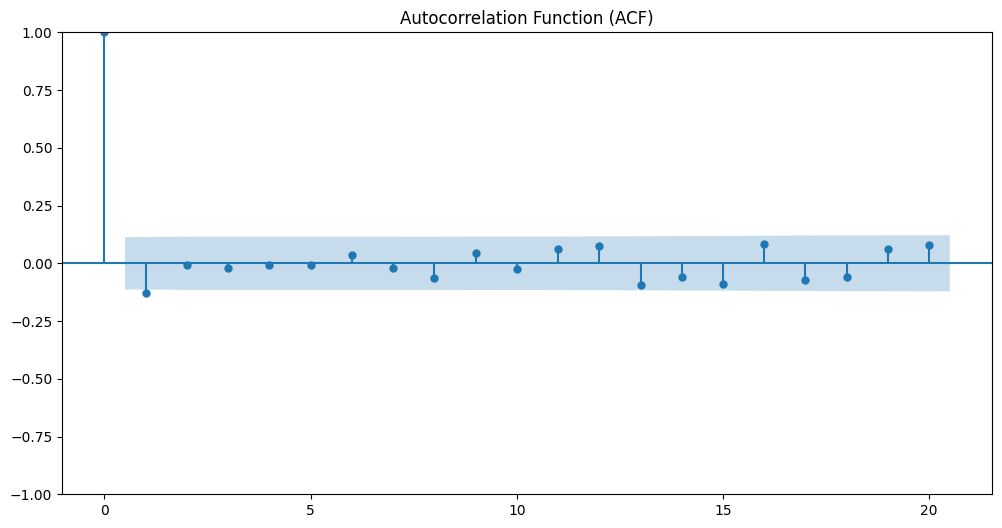

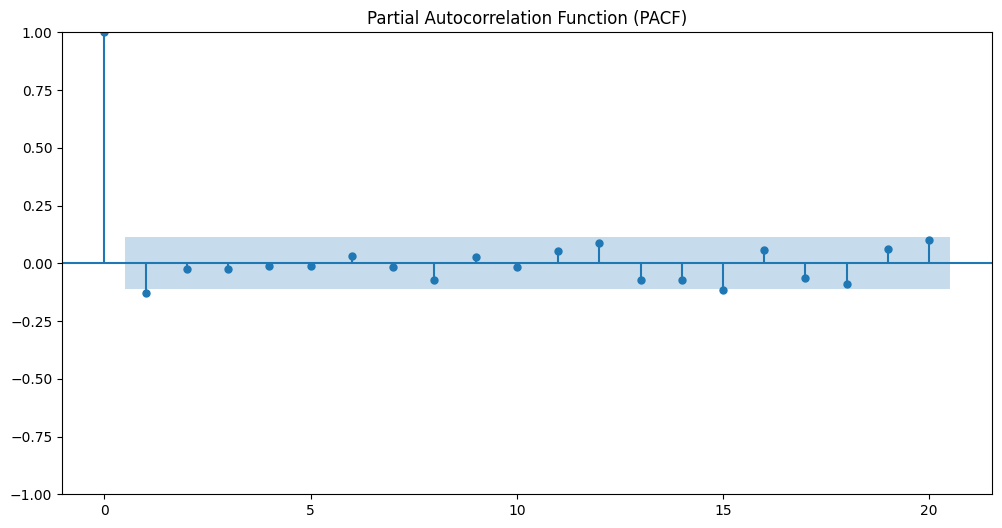

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame with columns 'Date' and 'Close'

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(train['Close_diff'], lags=20, ax=plt.gca())  # Adjust 'lags' as needed
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(train['Close_diff'], lags=20, ax=plt.gca())  # Adjust 'lags' as needed
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()


ACF Plot:
In this plot, the first two autocorrelations are significant, indicating a strong positive correlation with the two preceding values, suggesting an upward trend. The remaining autocorrelations are not statistically significant.Value of q=1.

PACF plot:
In the PACF plot, the first autocorrelation is outside of the blue area, which means that it is statistically significant. This suggests that there is a strong partial correlation between the current value of the time series and its value one time period ago, after controlling for the effects of all shorter lags.Vlue of p=1.

Also ,both the grpahs have  a significant spike at lag 1, it suggests that the series might be first differenced 



## Feature Engineering

In [20]:
def create_sarimax_features(data):
    
   
    data['Open_Lag1'] = data['Open'].shift(1)
    data['Open_Lag2'] = data['Open'].shift(2)
    data['Open_Lag3'] = data['Open'].shift(3)
    data['Open_Lag4'] = data['Open'].shift(4)
    
    # Calculate Moving Averages
    data['SMA_5_Open'] = data['Open'].rolling(window=5).mean()
    
    data['EMA_5_Open'] = data['Open'].ewm(span=5, adjust=False).mean()
    
    
    data['SMA_10_Volume'] = data['Volume'].rolling(window=10).mean()
    
    
    
    data.fillna(method='bfill', inplace=True)

    return data

Features Created for prediction of Close Prices:

Open_Lag1 to Open_Lag4: These are lag features representing the past opening prices of the stock, where Open_Lag1 is the opening price of the previous day, Open_Lag2 is the price from two days ago, and so on. These features capture the historical behavior of the stock.

SMA_5_Open: This is the Simple Moving Average (SMA) of the opening prices over a 5-day window.SMAs provide a smoothed representation of the price trend, helping to identify patterns and trends in the data.

EMA_5_Open: Similar to the SMA, this is the Exponential Moving Average (EMA) of the opening prices over a 5-day period. EMA gives more weight to recent data points, making it sensitive to short-term price movements.

SMA_10_Volume: This feature calculates the SMA of the trading volume over a 10-day window. Volume is important for analyzing market activity and liquidity.

In [21]:
def create_classifier_features(data):
    # Lag features (example: lag 1 and lag 2 for Close)
    data['Close_Lag1'] = data['Close'].shift(1)
    data['Close_Lag2'] = data['Close'].shift(2)
    data['Close_diff'] = data['Close'].diff()


    # Window features (example: rolling mean and standard deviation)
    window_size = 3  # Choose an appropriate window size
    data['Close_Rolling_Mean'] = data['Close'].rolling(window=window_size).mean()
    data['Close_Rolling_Std'] = data['Close'].rolling(window=window_size).std()
    
    # - Moving Average Convergence Divergence (MACD)
    data['ShortEMA'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['LongEMA'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['ShortEMA'] - data['LongEMA']


    # Example for RSI
    window = 14  # Adjust as needed
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi

    # Example for Bollinger Bands
    window = 20  # Adjust as needed
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    

    # Example for Price Rate of Change (ROC)
    n = 12  # Adjust as needed
    data['ROC'] = (data['Close'] / data['Close'].shift(n) - 1) * 100

    # Example for Moving Average Crossover
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()
   
    
    data.fillna(method='bfill', inplace=True)

    return data

Features Created for predicting categorical variable(strategy):

Close_Lag1 and Close_Lag2: These are lag features of the closing prices, similar to the opening prices. They capture historical price behavior.

Close_diff: This is the difference between consecutive closing prices. It measures the daily price change.

Close_Rolling_Mean and Close_Rolling_Std: These are window features that calculate the rolling mean and standard deviation of the closing prices over a specified window size (in this case, 3 days). They provide insights into short-term price volatility and trends.

ShortEMA, LongEMA, and MACD: These features are related to the Moving Average Convergence Divergence (MACD), which is a trend-following momentum indicator. It consists of the short-term EMA (12 days), long-term EMA (26 days), and the MACD line itself. It helps identify changes in the strength, direction, and momentum of the stock's trend.

RSI (Relative Strength Index): RSI is a momentum oscillator that measures the speed and change of price movements. It's calculated based on the 14-day price change and helps identify overbought or oversold conditions.

Bollinger Bands (SMA and STD): Bollinger Bands consist of an SMA (in this case, over 20 days) and the standard deviation of the closing prices. They are used to identify volatility and potential price reversal points.

ROC (Price Rate of Change): ROC measures the percentage change in closing prices over a specified number of days (in this case, 12 days). It helps identify the speed of price changes.

Moving Average Crossover (MA_50 and MA_20): These features represent the crossover of two moving averages. MA_50 is the 50-day moving average, and MA_20 is the 20-day moving average. Crossovers are used to identify potential buy or sell signals.


In [22]:
train = create_sarimax_features(train)
train = create_classifier_features(train)

Trying out the values p=0,q=0,d=1 to build the arima model

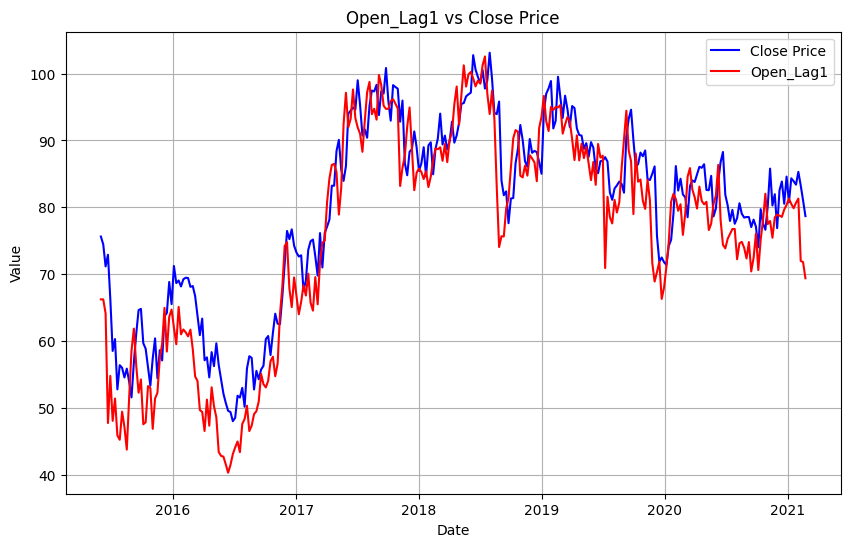

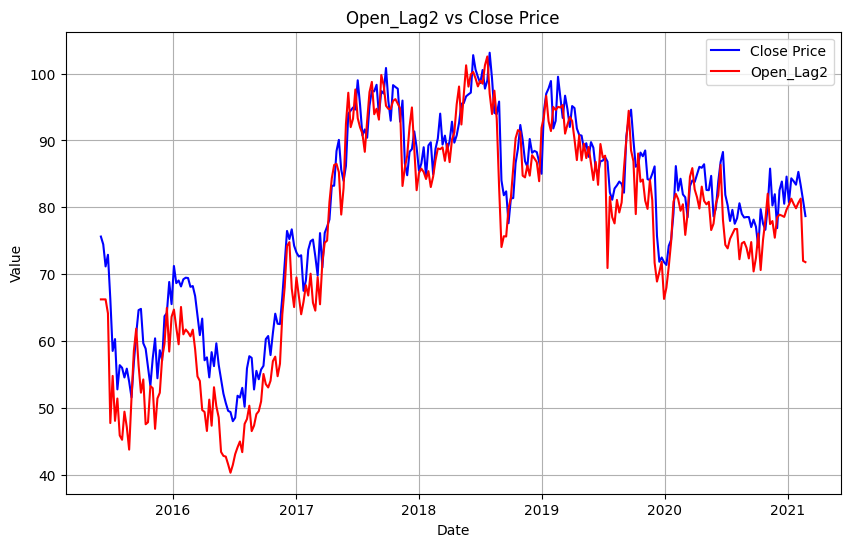

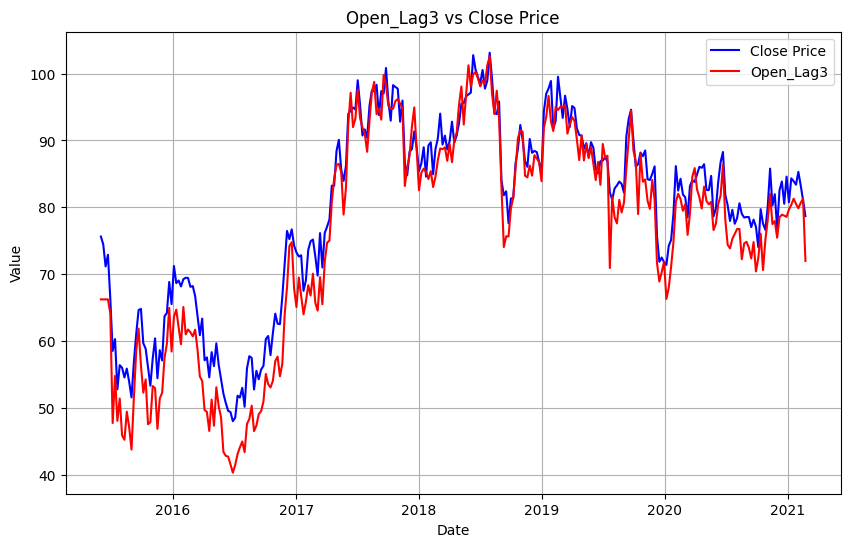

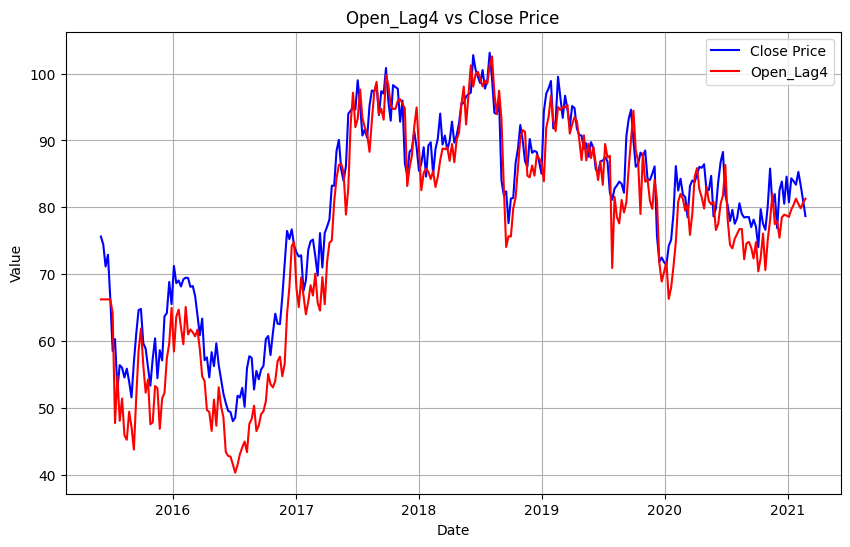

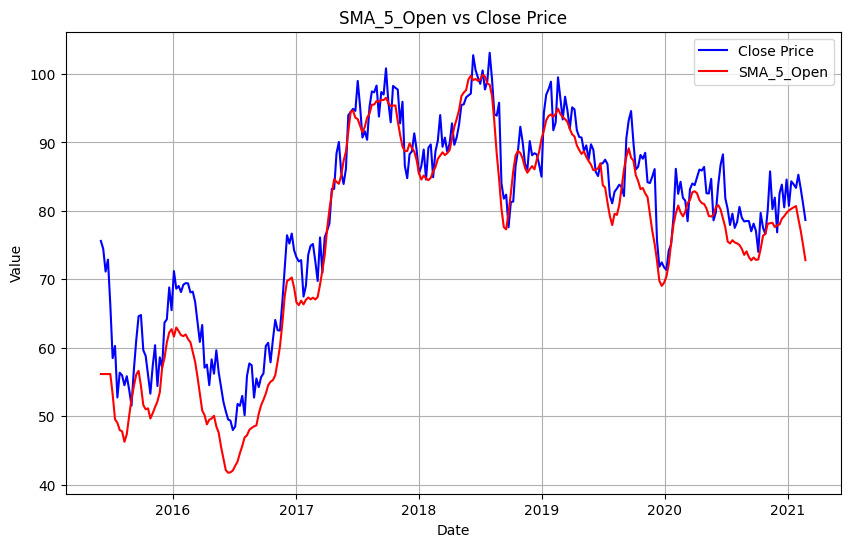

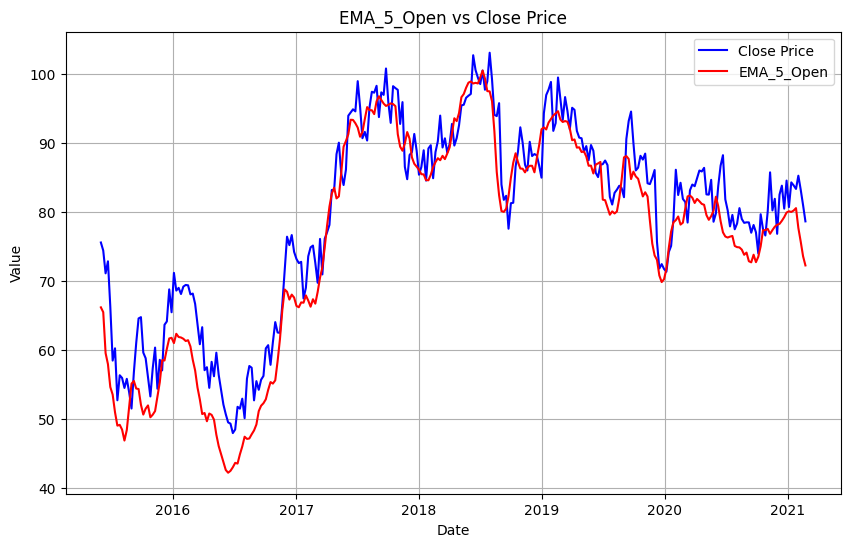

In [23]:
import matplotlib.pyplot as plt

def plot_feature_vs_close(data, feature_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train['Close'], label='Close Price', color='blue')
    plt.plot(train[feature_name], label=feature_name, color='red')
    plt.title(f'{feature_name} vs Close Price')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Replace 'your_dataframe' with your actual DataFrame
# Iterate over the feature names you want to plot
feature_name = ['Open_Lag1', 'Open_Lag2', 'Open_Lag3', 'Open_Lag4', 'SMA_5_Open', 'EMA_5_Open']
for feature in feature_name:
    plot_feature_vs_close(train,feature)

The above graphs demonstrate the significant relevance of these features, indicating their potential to enhance accuracy.

##  Splitting the train data

In [24]:
# Define the split point (e.g., 80% train, 20% test)
split_point = int(len(train) * 0.8)
train_data = train.iloc[:split_point]
test_data = train.iloc[split_point:]
print(f"Train data shape:{train_data.shape}\nTest_data shape:{test_data.shape}")

Train data shape:(240, 26)
Test_data shape:(60, 26)


In [25]:
train_data.columns

Index(['id', 'Open', 'Close', 'Volume', 'Strategy', 'Close_diff', 'Open_Lag1',
       'Open_Lag2', 'Open_Lag3', 'Open_Lag4', 'SMA_5_Open', 'EMA_5_Open',
       'SMA_10_Volume', 'Close_Lag1', 'Close_Lag2', 'Close_Rolling_Mean',
       'Close_Rolling_Std', 'ShortEMA', 'LongEMA', 'MACD', 'RSI', 'SMA', 'STD',
       'ROC', 'MA_50', 'MA_20'],
      dtype='object')

In [26]:
test_data.columns

Index(['id', 'Open', 'Close', 'Volume', 'Strategy', 'Close_diff', 'Open_Lag1',
       'Open_Lag2', 'Open_Lag3', 'Open_Lag4', 'SMA_5_Open', 'EMA_5_Open',
       'SMA_10_Volume', 'Close_Lag1', 'Close_Lag2', 'Close_Rolling_Mean',
       'Close_Rolling_Std', 'ShortEMA', 'LongEMA', 'MACD', 'RSI', 'SMA', 'STD',
       'ROC', 'MA_50', 'MA_20'],
      dtype='object')

# Creating Sarimax Model

In [27]:
import statsmodels.api as sm

order = (1, 0, 1)
seasonal_order = (5, 0, 0, 5)

# Define the exogenous variables
exog_train = train_data[['Open', 'Volume', 'Open_Lag1','Open_Lag2','Open_Lag3','Open_Lag4', 'SMA_5_Open', 'EMA_5_Open','SMA_10_Volume']]
exog_test = test_data[['Open', 'Volume', 'Open_Lag1','Open_Lag2','Open_Lag3','Open_Lag4', 'SMA_5_Open', 'EMA_5_Open','SMA_10_Volume']]

# Define the SARIMAX model with exogenous variables
model = sm.tsa.statespace.SARIMAX(
    train_data['Close'],
    exog=exog_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=True,  # Enforce stationarity
    enforce_invertibility=True   # Enforce invertibility
)

# Fit the model
result = model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13855D+00    |proj g|=  6.52417D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17      1     21      1     0     0   6.524D+09   2.139D+00
  F =   2.1385458869261815     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


After numerous trial and error the best fitting seasonal and non seasonal order picked are (1,0,1),(5,0,0,5).We are modelling  the time series with an autoregressive (AR) component of order 1, no differencing, and a moving average (MA) component of order 1 for the non-seasonal part. For the seasonal part, we have used a seasonal AR component of order 5 and no seasonal differencing (d = 0) with a seasonal MA component of order

Even though the time series is non-stationary, but the SARIMA model with (D=0) and (d=0) is performing better, this suggests that the model is able to capture the non-stationarity without differencing. 
The SARIMA model we're using seems to  be complex enough to capture the underlying patterns in the data, including trends and seasonality, without the need for differencing. The additional features we've included in the model (Open_Lag1,Open_Lag2,Open_Lag3,Open_Lag4,SMA_5_Open,EMA_5_Open,SMA_10_Volume) is compensating for the lack of differencing.



### Predicting the Close values

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



Predicted Values:
2020-01-06    72.858079
2020-01-13    72.397939
2020-01-20    74.040295
2020-01-27    78.557921
2020-02-03    82.319460
2020-02-10    85.371588
2020-02-17    84.276901
2020-02-24    81.571261
2020-03-02    82.735190
2020-03-09    80.028150
2020-03-16    82.156128
2020-03-23    84.732584
2020-03-30    85.854180
2020-04-06    84.949509
2020-04-13    82.788140
2020-04-20    82.641315
2020-04-27    83.345473
2020-05-04    82.206976
2020-05-11    81.752981
2020-05-18    81.251169
2020-05-25    80.303603
2020-06-01    80.083909
2020-06-08    81.289017
2020-06-15    82.699547
2020-06-22    84.298031
2020-06-29    81.472590
2020-07-06    77.947243
2020-07-13    76.490745
2020-07-20    77.573263
2020-07-27    77.954980
2020-08-03    78.590178
2020-08-10    77.931877
2020-08-17    75.689834
2020-08-24    76.451906
2020-08-31    76.663888
2020-09-07    76.090387
2020-09-14    74.450322
2020-09-21    75.111506
2020-09-28    73.856879
2020-10-05    74.222071
2020-10-12    77.22712

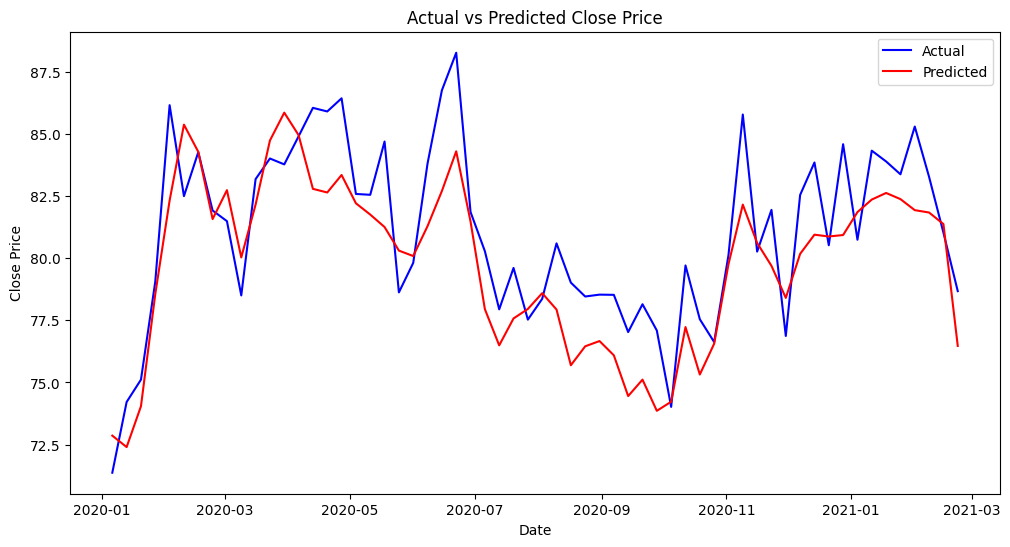

In [28]:
# Make predictions on the test set
preds = result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=exog_test, typ='levels')

# Print predicted values
print("Predicted Values:")
print(preds)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Calculate SMAPE
smape_value = smape(test_data['Close'], preds)
print(f'SMAPE: {smape_value}')

# Plot actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Close'], label='Actual', color='blue')
plt.plot(test_data.index, preds, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()


The given graph shows the actual vs predicted closing prices of a stock using a time series model. The model is able to capture the overall trend of the stock's closing prices. The model is more accurate in predicting the stock's closing prices during periods of low volatility. The model is less accurate in predicting the stock's closing prices during periods of high volatility.

In [29]:
#checking the count of each strategy
print(np.unique(train_data['Strategy'], return_counts=True))

(array(['Buy', 'Hold', 'Sell'], dtype=object), array([ 61, 113,  66]))


### Training the Classifier

In [30]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
# Initialize LabelEncoder
le = LabelEncoder()

# For training data
X_train = train_data[['Open', 'Close', 'Volume', 'Close_diff', 'Close_Lag1', 'Close_Lag2', 'Close_Rolling_Mean',
       'Close_Rolling_Std','RSI', 'SMA', 'STD', 'ROC', 'MA_50', 'MA_20','ShortEMA','LongEMA','MACD', 'Open_Lag1','Open_Lag2'
        ,'Open_Lag3', 'Open_Lag4', 'SMA_5_Open', 'EMA_5_Open','SMA_10_Volume']]
y_train = le.fit_transform(train_data['Strategy'])

# For test data
X_test = test_data[['Open', 'Close', 'Volume', 'Close_diff', 'Close_Lag1', 'Close_Lag2', 'Close_Rolling_Mean',
       'Close_Rolling_Std','RSI', 'SMA', 'STD', 'ROC', 'MA_50', 'MA_20','ShortEMA','LongEMA','MACD', 'Open_Lag1','Open_Lag2'
        ,'Open_Lag3', 'Open_Lag4', 'SMA_5_Open', 'EMA_5_Open','SMA_10_Volume']]
y_test = le.transform(test_data['Strategy'])



# Initialize classifiers with adjusted hyperparameters
lgbm_classifier = lgb.LGBMClassifier(
    boosting_type='dart',  
    learning_rate=0.1,    
    num_iterations=200,   
    max_depth=3,           
    num_leaves=31,         
    max_bins=30
)

xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,  
    n_estimators=100,  
    max_depth=3,        
    min_child_weight=1,
    gamma=0,            
    subsample=0.8,       
    colsample_bytree=0.8,      
    scale_pos_weight=1, 
    seed=42 
)

# Create a Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[('lgbm', lgbm_classifier), ('xgb', xgb_classifier)],
    voting='soft' 
)

# Initialize the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),     
    ('selector', SelectKBest(f_classif, k=6)),  # Selecting top k features
    ('classifier', voting_classifier)  
])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make Predictions
predictions = pipeline.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Classification Report:')
print(classification_rep)

# Access individual classifier models from the voting classifier
lgbm_model = pipeline.named_steps['classifier'].estimators_[0]
xgb_model = pipeline.named_steps['classifier'].estimators_[1]

# Access feature importances
lgbm_feature_importances = lgbm_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Print feature importances for LightGBM
print("LightGBM Feature Importances:")
for feature, importance in zip(X_train.columns, lgbm_feature_importances):
    print(f"{feature}: {importance}")

# Print feature importances for XGBoost
print("\nXGBoost Feature Importances:")
for feature, importance in zip(X_train.columns, xgb_feature_importances):
    print(f"{feature}: {importance}")

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[18:31:55] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Accuracy: 71.67%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        17
           1       0.74      0.67      0.70        30
           2       0.62      0.62      0.62        13

    accuracy                           0.72        60
   macro avg       0.70      0.72      0.71        60
weighted avg       0.72      0.72      0.71        60

LightGBM Feature Importances:
Open: 335
Close: 567
Volume: 620
Close_diff: 590
Close_Lag1: 656
Close_Lag2: 274

XGBoost Feature Importances:
Open: 0.11044042557477951
Close: 0.11538462340831757
Volume: 0.29847198724746704
Close_diff: 0.23044763505458832
Close_Lag1: 0.14357145130634308
Close_Lag2: 0.1016838401556015


After extensive model training and experimentation with various classifiers and ensemble methods, we ultimately opted for a combination of XGBoost and LightGBM. 
Stock price movements are often driven by non-linear and complex dynamics. LightGBM and XGBoost excel at capturing non-linear relationships between input features (e.g., historical price data, volume, technical indicators like SMA ,EMA and MACD) and stock price changes.This ensemble effectively incorporates critical features while mitigating overfitting. Moreover, the chosen ensemble method exhibits reduced sensitivity to noise and outliers in the data. The model parameters were meticulously selected after multiple iterations and thorough fine-tuning.

In [31]:
# best features
cols = X_train.columns[pipeline['selector'].get_support(indices=True)]
print(cols)

Index(['Close', 'Close_diff', 'RSI', 'ROC', 'MACD', 'Open_Lag3'], dtype='object')


Based on the aforementioned outcome, the crucial features are identified as 'Close', 'Close_diff', 'RSI', 'ROC', 'MACD', and 'Open_Lag3'. Despite not differencing the time series, the inclusion of 'Close_diff' significantly enhances accuracy, compensating for the absence of differencing.

## Training the model on entire training data

In [32]:
## CROSS VALIDATION
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline['classifier'], X_train, y_train, cv=5)
scores

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[18:31:56] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[18:31:57] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[18:31:58] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[18:31:59] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[18:32:00] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



array([0.66666667, 0.6875    , 0.83333333, 0.625     , 0.77083333])

Cross-validation assesses the model's ability to generalize well to unseen data. By splitting the training data into multiple subsets, it evaluates the model's performance on different combinations of training and validation sets.The accuracies seem to be good enough

In [33]:
##TRAINING THE CLASSIFIER ON ENTIRE TRAIN DATA AND TESTING IT ON THE SAME
# Step 1: Combine Training and Test Data
combined_data = pd.concat([train_data, test_data])

# Steps 2-4: Initialize LabelEncoder and Classifiers
le = LabelEncoder()

# Extract features and labels
X = combined_data[['Open', 'Close', 'Volume', 'Close_diff', 'Close_Lag1', 'Close_Lag2', 'Close_Rolling_Mean',
       'Close_Rolling_Std','RSI', 'SMA', 'STD', 'ROC', 'MA_50', 'MA_20','ShortEMA','LongEMA','MACD', 'Open_Lag1','Open_Lag2'
        ,'Open_Lag3', 'Open_Lag4', 'SMA_5_Open', 'EMA_5_Open','SMA_10_Volume']]  # Include all features
y = le.fit_transform(combined_data['Strategy'])


    # Initialize classifiers with adjusted hyperparameters
lgbm_classifier = lgb.LGBMClassifier(
    boosting_type='dart',  
    learning_rate=0.1,    
    num_iterations=200,   
    max_depth=3,           
    num_leaves=31,         
    max_bins=30
)

xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,  # Adjust learning rate
    n_estimators=100,   # Increase the number of boosting rounds
    max_depth=3,        
    min_child_weight=1,
    gamma=1,            
    subsample=0.8,       # Decrease subsample ratio
    colsample_bytree=0.8,# Decrease subsample ratio for columns       
    scale_pos_weight=1, 
    seed=42 
)

voting_classifier = VotingClassifier(
    estimators=[('lgbm', lgbm_classifier), ('xgb', xgb_classifier)],
    voting='soft'
)

# Steps 5-6: Initialize the Pipeline and Train the Model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif, k=6)),
    ('classifier', voting_classifier)
])

pipeline.fit(X, y)

# Step 7: Make Predictions
predictions = pipeline.predict(X)

# Step 8: Evaluate the Model
accuracy = accuracy_score(y, predictions)
classification_rep = classification_report(y, predictions)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Classification Report:')
print(classification_rep)

# Access individual classifier models from the voting classifier
lgbm_model = pipeline.named_steps['classifier'].estimators_[0]
xgb_model = pipeline.named_steps['classifier'].estimators_[1]

# Access feature importances
lgbm_feature_importances = lgbm_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Print feature importances for LightGBM
print("LightGBM Feature Importances:")
for feature, importance in zip(X.columns, lgbm_feature_importances):
    print(f"{feature}: {importance}")

# Print feature importances for XGBoost
print("\nXGBoost Feature Importances:")
for feature, importance in zip(X.columns, xgb_feature_importances):
    print(f"{feature}: {importance}")


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[18:32:01] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Accuracy: 96.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        78
           1       0.97      0.94      0.96       143
           2       0.94      0.99      0.96        79

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300

LightGBM Feature Importances:
Open: 355
Close: 671
Volume: 726
Close_diff: 496
Close_Lag1: 767
Close_Lag2: 154

XGBoost Feature Importances:
Open: 0.1039355993270874
Close: 0.14073464274406433
Volume: 0.36423346400260925
Close_diff: 0.15329228341579437
Close_Lag1: 0.15531954169273376
Close_Lag2: 0.08248446881771088


Retraining a model on the full training dataset, after an initial split into training and test sets, offers several advantages:

-->Maximizing Information for Training: This ensures the model benefits from the maximum available data during training, potentially leading to better performance.

-->Optimizing Data Utilization: Particularly useful with limited dataset sizes, leveraging the entire dataset can significantly enhance model performance.

In [34]:
# best features
cols = X_train.columns[pipeline['selector'].get_support(indices=True)]
print(cols)

Index(['Close', 'Close_diff', 'RSI', 'ROC', 'MACD', 'Open_Lag3'], dtype='object')


# Now on test data (Predicting the values and Strategy)

In [35]:
print('1',train['Close'].index)
print('2',exog_train.index)

1 DatetimeIndex(['2015-06-01', '2015-06-08', '2015-06-15', '2015-06-22',
               '2015-06-29', '2015-07-06', '2015-07-13', '2015-07-20',
               '2015-07-27', '2015-08-03',
               ...
               '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
               '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08',
               '2021-02-15', '2021-02-22'],
              dtype='datetime64[ns]', name='Date', length=300, freq=None)
2 DatetimeIndex(['2015-06-01', '2015-06-08', '2015-06-15', '2015-06-22',
               '2015-06-29', '2015-07-06', '2015-07-13', '2015-07-20',
               '2015-07-27', '2015-08-03',
               ...
               '2019-10-28', '2019-11-04', '2019-11-11', '2019-11-18',
               '2019-11-25', '2019-12-02', '2019-12-09', '2019-12-16',
               '2019-12-23', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=240, freq=None)


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2015-06-01 to 2021-02-22
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  300 non-null    int64  
 1   Open                300 non-null    float64
 2   Close               300 non-null    float64
 3   Volume              300 non-null    int64  
 4   Strategy            300 non-null    object 
 5   Close_diff          300 non-null    float64
 6   Open_Lag1           300 non-null    float64
 7   Open_Lag2           300 non-null    float64
 8   Open_Lag3           300 non-null    float64
 9   Open_Lag4           300 non-null    float64
 10  SMA_5_Open          300 non-null    float64
 11  EMA_5_Open          300 non-null    float64
 12  SMA_10_Volume       300 non-null    float64
 13  Close_Lag1          300 non-null    float64
 14  Close_Lag2          300 non-null    float64
 15  Close_Rolling_Mean  300 non-null    fl

In [37]:
test.head()

,Date,Open,Volume
id,,,
0,2021-03-01,72.708331,205897600
1,2021-03-08,73.310886,214095600
2,2021-03-15,70.610119,151601700
3,2021-03-22,70.256017,193982500
4,2021-03-29,68.258324,220238400


In [38]:
ids = test.index
ids

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype='int64', name='id')

In [39]:
#test.set_index('Date', inplace=True)
test=create_sarimax_features(test)

In [40]:
#Backfilling the null values after feature creation
test.fillna(method='bfill',inplace=True)
test.fillna(method='ffill',inplace=True)

In [41]:
test.columns

Index(['Date', 'Open', 'Volume', 'Open_Lag1', 'Open_Lag2', 'Open_Lag3',
       'Open_Lag4', 'SMA_5_Open', 'EMA_5_Open', 'SMA_10_Volume'],
      dtype='object')

In [42]:
## TRAINING THE MODEL AGAIN ON THE ENTIRE TRAIN DATA 
import statsmodels.api as sm


# Define the exogenous variables 
exog_test = test[['Open', 'Volume', 'Open_Lag1','Open_Lag2','Open_Lag3','Open_Lag4', 'SMA_5_Open', 'EMA_5_Open','SMA_10_Volume']]
exog_train = train[['Open', 'Volume', 'Open_Lag1','Open_Lag2','Open_Lag3','Open_Lag4', 'SMA_5_Open', 'EMA_5_Open','SMA_10_Volume']]

# Define the SARIMAX model with exogenous variables
model = sm.tsa.statespace.SARIMAX(train['Close'], exog=exog_train, order=(1, 0, 1))

# Fit the model
result = model.fit()


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-MON will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06917D+00    |proj g|=  5.91764D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      1     21      1     0     0   5.918D+09   2.069D+00
  F =   2.0691726346552590     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [43]:
# Make predictions on the test set
preds = result.predict(start=len(train), end=len(train) + len(test) - 1, exog=exog_test, typ='levels')

# Print predicted values
print("Predicted Values:")
print(preds)


Predicted Values:
2021-03-01    77.258020
2021-03-08    77.261907
2021-03-15    77.151929
2021-03-22    77.092372
2021-03-29    77.204428
                ...    
2022-12-26    63.183570
2023-01-02    62.786633
2023-01-09    61.187815
2023-01-16    61.843400
2023-01-23    63.831991
Freq: W-MON, Name: predicted_mean, Length: 100, dtype: float64


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [44]:
print(len(preds))

100


In [45]:
test['Close']=preds.values

In [46]:
test = create_classifier_features(test)

In [47]:
print(test['Close'])

id
0     77.258020
1     77.261907
2     77.151929
3     77.092372
4     77.204428
        ...    
95    63.183570
96    62.786633
97    61.187815
98    61.843400
99    63.831991
Name: Close, Length: 100, dtype: float64


In [48]:
test.head()

,Date,Open,Volume,Open_Lag1,Open_Lag2,Open_Lag3,Open_Lag4,SMA_5_Open,EMA_5_Open,SMA_10_Volume,...,Close_Rolling_Std,ShortEMA,LongEMA,MACD,RSI,SMA,STD,ROC,MA_50,MA_20
id,,,,,,,,,,,,,,,,,,,,,
0,2021-03-01,72.708331,205897600,72.708331,72.708331,72.708331,72.708331,71.028735,72.708331,204137180.0,...,0.062404,77.258020,77.258020,0.000000,39.666751,75.579422,1.4393,-4.483121,78.837539,75.579422
1,2021-03-08,73.310886,214095600,72.708331,72.708331,72.708331,72.708331,71.028735,72.909183,204137180.0,...,0.062404,77.258618,77.258308,0.000310,39.666751,75.579422,1.4393,-4.483121,78.837539,75.579422
2,2021-03-15,70.610119,151601700,73.310886,72.708331,72.708331,72.708331,71.028735,72.142828,204137180.0,...,0.062404,77.242205,77.250428,-0.008224,39.666751,75.579422,1.4393,-4.483121,78.837539,75.579422
3,2021-03-22,70.256017,193982500,70.610119,73.310886,72.708331,72.708331,71.028735,71.513891,204137180.0,...,0.086008,77.219153,77.238720,-0.019567,39.666751,75.579422,1.4393,-4.483121,78.837539,75.579422
4,2021-03-29,68.258324,220238400,70.256017,70.610119,73.310886,72.708331,71.028735,70.428702,204137180.0,...,0.056065,77.216888,77.236180,-0.019292,39.666751,75.579422,1.4393,-4.483121,78.837539,75.579422


In [49]:
print(test.columns.array)

<PandasArray>
[              'Date',               'Open',             'Volume',
          'Open_Lag1',          'Open_Lag2',          'Open_Lag3',
          'Open_Lag4',         'SMA_5_Open',         'EMA_5_Open',
      'SMA_10_Volume',              'Close',         'Close_Lag1',
         'Close_Lag2',         'Close_diff', 'Close_Rolling_Mean',
  'Close_Rolling_Std',           'ShortEMA',            'LongEMA',
               'MACD',                'RSI',                'SMA',
                'STD',                'ROC',              'MA_50',
              'MA_20']
Length: 25, dtype: object


In [50]:
# Define the features for prediction
test_1 = test[['Open', 'Close', 'Volume', 'Close_diff', 'Close_Lag1', 'Close_Lag2', 'Close_Rolling_Mean',
       'Close_Rolling_Std','RSI', 'SMA', 'STD', 'ROC', 'MA_50', 'MA_20','ShortEMA','LongEMA','MACD', 'Open_Lag1','Open_Lag2'
        ,'Open_Lag3', 'Open_Lag4', 'SMA_5_Open', 'EMA_5_Open','SMA_10_Volume']]

# Make Predictions
predictions_vc = pipeline.predict(test_1)

# Assuming 'le' is your LabelEncoder
predicted_labels = le.inverse_transform(predictions_vc)

# Add the predictions to the test DataFrame
test['Predicted_Strategy'] = predicted_labels

In [51]:
test.head(30)

,Date,Open,Volume,Open_Lag1,Open_Lag2,Open_Lag3,Open_Lag4,SMA_5_Open,EMA_5_Open,SMA_10_Volume,...,ShortEMA,LongEMA,MACD,RSI,SMA,STD,ROC,MA_50,MA_20,Predicted_Strategy
id,,,,,,,,,,,,,,,,,,,,,
0,2021-03-01,72.708331,205897600,72.708331,72.708331,72.708331,72.708331,71.028735,72.708331,204137180.0,...,77.258020,77.258020,0.000000,39.666751,75.579422,1.439300,-4.483121,78.837539,75.579422,Buy
1,2021-03-08,73.310886,214095600,72.708331,72.708331,72.708331,72.708331,71.028735,72.909183,204137180.0,...,77.258618,77.258308,0.000310,39.666751,75.579422,1.439300,-4.483121,78.837539,75.579422,Buy
2,2021-03-15,70.610119,151601700,73.310886,72.708331,72.708331,72.708331,71.028735,72.142828,204137180.0,...,77.242205,77.250428,-0.008224,39.666751,75.579422,1.439300,-4.483121,78.837539,75.579422,Buy
3,2021-03-22,70.256017,193982500,70.610119,73.310886,72.708331,72.708331,71.028735,71.513891,204137180.0,...,77.219153,77.238720,-0.019567,39.666751,75.579422,1.439300,-4.483121,78.837539,75.579422,Buy
4,2021-03-29,68.258324,220238400,70.256017,70.610119,73.310886,72.708331,71.028735,70.428702,204137180.0,...,77.216888,77.236180,-0.019292,39.666751,75.579422,1.439300,-4.483121,78.837539,75.579422,Buy
5,2021-04-05,69.625390,252489500,68.258324,70.256017,70.610119,73.310886,70.412147,70.160931,204137180.0,...,76.971442,77.116573,-0.145132,39.666751,75.579422,1.439300,-4.483121,78.837539,75.579422,Buy
6,2021-04-12,72.046746,178234600,69.625390,68.258324,70.256017,70.610119,70.159319,70.789536,204137180.0,...,76.631830,76.942306,-0.310476,39.666751,75.579422,1.439300,-4.483121,78.837539,75.579422,Buy
7,2021-04-19,71.426418,194482300,72.046746,69.625390,68.258324,70.256017,70.322579,71.001830,204137180.0,...,76.193928,76.708466,-0.514538,39.666751,75.579422,1.439300,-4.483121,78.837539,75.579422,Buy
8,2021-04-26,70.060497,235236100,71.426418,72.046746,69.625390,68.258324,70.283475,70.688053,204137180.0,...,75.922395,76.539614,-0.617219,39.666751,75.579422,1.439300,-4.483121,78.837539,75.579422,Buy


# Your model creation, training and inferencing code, along with suitable analysis and reasoning!

In [52]:
submission = pd.DataFrame()
submission["Date"] = test.index

In [53]:
sample_submission = pd.read_csv('/kaggle/input/ue21cs342aa2/sample_submission.csv', index_col = 0)

In [54]:
ids

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype='int64', name='id')

In [55]:
submission.index = ids
submission["Close"] = preds.values
submission["Strategy"] = predicted_labels

In [56]:
predicted_labels

array(['Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Buy', 'Hold', 'Hold', 'Buy',
       'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Sell', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Hold', 'Sell', 'Sell',
       'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Sell', 'Hold', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Hold', 'Hold', 'Hold', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Hold',
       'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Hold'], dtype=object)

In [57]:
submission.head()

,Date,Close,Strategy
id,,,
0,0,77.258020,Buy
1,1,77.261907,Buy
2,2,77.151929,Buy
3,3,77.092372,Buy
4,4,77.204428,Buy


In [58]:
submission.to_csv('submission.csv',index=True)

<Axes: xlabel='Date', ylabel='Close'>

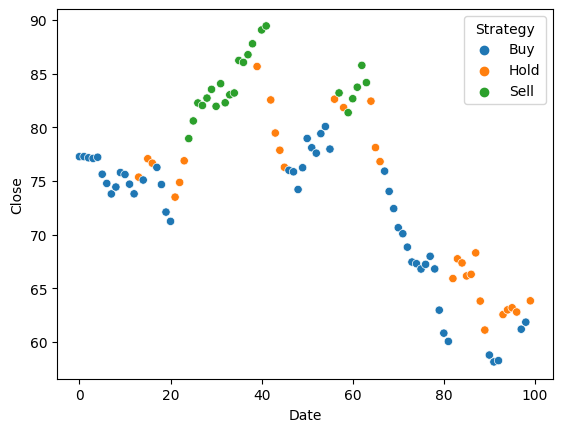

In [59]:
sns.scatterplot(x='Date', y='Close', hue='Strategy', data=submission)

In summary, the graph displays a robust pattern: we sell at higher prices, buy at lower prices, and hold during periods of stable or no significant trend in either direction.So ,seems like we are good to go 

### In the cell above, we have just provided an example of how to create your submission DataFrame. Please make sure to use **your own forecasts and predictions**, in place of `sample_submission["Close"]` and `sample_submission["Strategy"]`

In [60]:
submission.head()

,Date,Close,Strategy
id,,,
0,0,77.258020,Buy
1,1,77.261907,Buy
2,2,77.151929,Buy
3,3,77.092372,Buy
4,4,77.204428,Buy


In [61]:
submission.to_csv('submission.csv', index=True)